# $\rho'$ analysis notes

## GIRD Selection criteria:

These criteria were applied on the selection stage(GRID):

Events:

- \>= 4 tracks
    
Tracks:

- Has Point On inner OR outer ITS Layer
- Not ITS SA
- |dca1| < 3 && |dca0| < 3;

### Data info

In [1]:
from modules.FourTrackEvents import *
from modules.physics import kinematics
from modules.physics.analysis.ITSvsTPC_events import *
from modules.physics.analysis.crossection import GetCrossSection

%matplotlib widget
if os_name == 'posix':
    %jsroot on

# dfs.loc[0] # get dataframe part with entry = 0
ft = FourTrackEvents()

print('Events attributes:')
print(ft.orig_events.columns.tolist())
print('Track attributes:')
print(ft.orig_tracks.columns.tolist())
print()
print('Events count:', "{:,}".format(len(ft.orig_events.index)))
print('Tracks count:', "{:,}".format(len(ft.orig_tracks.index)))

Events attributes:
['RunNum', 'PeriodNumber', 'OrbitNumber', 'BunchCrossNumber', 'Mass', 'Pt', 'Q', 'Rapidity', 'Phi', 'ZNAenergy', 'ZNCenergy', 'ZPAenergy', 'ZPCenergy', 'VtxX', 'VtxY', 'VtxZ', 'VtxContrib', 'VtxChi2', 'VtxNDF', 'SpdVtxX', 'SpdVtxY', 'SpdVtxZ', 'SpdVtxContrib', 'V0Adecision', 'V0Cdecision', 'ADAdecision', 'ADCdecision', 'V0Afired', 'V0Cfired', 'ADAfired', 'ADCfired', 'STPfired', 'SMBfired', 'SM2fired', 'SH1fired', 'OM2fired', 'OMUfired', 'IsTriggered', 'nTracklets', 'nTracks', 'FORChip']
Track attributes:
['T_NumberOfSigmaTPCPion', 'T_Eta', 'T_Phi', 'T_Px', 'T_Py', 'T_Pz', 'T_Q', 'T_HasPointOnITSLayer0', 'T_HasPointOnITSLayer1', 'T_ITSModuleInner', 'T_ITSModuleOuter', 'T_TPCNCls', 'T_TPCRefit']

Events count: 106,705
Tracks count: 25,117,847


## Analysis criteria

Let's take from input date only events with 4 tracks and zero total charge.
Also prepare mask for tracks that satisfy standatd criteria contains further conditions for the TPC:

* |NumberOfSigmaTPCPion| < 3
* Number of TPC Clusters > 50
* TPCRefit
## Low energy tracks and TPC

There is an idea about that tracks with small energies (low pt) not able to reach TPC.
We can try to estimate influence of TPC criteria to the statistics.

Let's see what happend in case of we will plot pt for any combination of TPC tracks:

### Event with std criteria

|detector|track1|track2|track3|track4|
|:--:|:--:|:--:|:--:|:--:|
|ITS|+|+|+|+|
|TPC|+|+|+|+|

### Let's start to take also such combinations to the sample:

|detector|track1|track2|track3|track4|
|:--:|:--:|:--:|:--:|:--:|
|ITS|+|+|+|+|
|TPC|+|+|+|-|

|detector|track1|track2|track3|track4|
|:--:|:--:|:--:|:--:|:--:|
|ITS|+|+|+|+|
|TPC|+|+|-|-|

|detector|track1|track2|track3|track4|
|:--:|:--:|:--:|:--:|:--:|
|ITS|+|+|+|+|
|TPC|+|-|-|-|

|detector|track1|track2|track3|track4|
|:--:|:--:|:--:|:--:|:--:|
|ITS|+|+|+|+|
|TPC|-|-|-|-|

We can see statistics gain ration equal 2.5 between std criteria and total combinations:


In [2]:
# ft - four tracks
# zq - zero charge
# nzq - non zero charge
# Pt - transversal momentum
# nTPc - each index(i) of list corresponding to case when more than i TPC tracks in event 
# e.g. ft_nzq_Pt_nTpc contains list of the list of four track events with non zero total charge
# where index (i) of the main list corresponding to case when more than i TPC tracks in event 

ft_zq_Pt_nTpc = []
ft_nzq_Pt_nTpc = []
ft_zq_Mass_nTpc = []
ft_nzq_Mass_nTpc = []
for i in range(5):
    ft_zq_Pt_nTpc.append(kinematics.pt_events(ft.ft_zq_nTPC[i]))
    ft_nzq_Pt_nTpc.append(kinematics.pt_events(ft.ft_nzq_nTPC[i]))
    ft_zq_Mass_nTpc.append(kinematics.mass_events(ft.GetTracksWithPtLt(ft.ft_zq_nTPC[i])))
    ft_nzq_Mass_nTpc.append(kinematics.mass_events(ft.GetTracksWithPtLt(ft.ft_nzq_nTPC[i])))

## False triggering

There are some situations when CCUP9 trigger could be fired false:
It may occured when some fake or random track fires FOR and trigger will provide.

We can check list of FORs of event and what chipkey has each of four tracks.
In case it has matches and produce back to back topology this means correct trigger state.

![img](https://sun9-58.userapi.com/impf/x7UtIW5ElLKpDl4ASPuz0FXhNjwnxYcAy0BuHw/wJZr1On9l4o.jpg?size=1280x718&quality=96&sign=1ed3d5f08fcdefd89ab4e02a5041c6d0&type=album)

See debugging details in [one of the issue](https://github.com/bdrum/cern-physics/issues/42)


In [283]:
# let's form fired FORs numbers for 4 tracks zq EVENT 
for_sensors = pd.DataFrame(ft.orig_events.FORChip.loc[ft.four_tracks_zq.reset_index().entry])
for_sensors['subentry']=for_sensors.groupby(level=0).cumcount()
for_sensors.index.name = 'entry'
for_sensors.set_index('subentry', append=True,inplace=True)

# form arrays of numbers of sensor that linked with TRACKS 
df = ft.four_tracks_zq[['T_ITSModuleInner','T_ITSModuleOuter']] // 1000000

# combine into one dataframe
df['T_ITSSensorNum'] = for_sensors
df = df.reset_index()

# check that sensor linked with track will provide trigger (match with FOR sensor)
df["Inner_matched"] = (abs(abs(df.T_ITSModuleInner*5 - df.T_ITSSensorNum) - 2).apply(lambda x: x <= 2)) * df.T_ITSSensorNum.apply(lambda x: x < 400)

df["Outer_matched"] = (abs(abs(df.T_ITSModuleOuter*5 - df.T_ITSSensorNum) - 2).apply(lambda x: x <= 2)) * df.T_ITSSensorNum.apply(lambda x: x >= 400)
df["vPhiInner"] = np.nan
df.vPhiInner = df.vPhiInner.astype('object')
df["vPhiOuter"] = np.nan
df.vPhiOuter = df.vPhiOuter.astype('object')

df["vPhiInnerValue"] = np.nan
df.vPhiInnerValue = df.vPhiInnerValue.astype('object')
df["vPhiOuterValue"] = np.nan
df.vPhiOuterValue = df.vPhiOuterValue.astype('object')

for i in tqdm(range(len(df))):
    vPhiInner1 = np.zeros(20, dtype=bool)
    vPhiOuter1 = np.zeros(40, dtype=bool)

    vPhiInnerValues = pd.unique(df.T_ITSSensorNum[i][df.Inner_matched[i]]//20)
    vPhiOuterValues = pd.unique((df.T_ITSSensorNum[i][df.Outer_matched[i]]-400)//20)

    vPhiInner1[vPhiInnerValues]=True
    df.vPhiInner[i] = vPhiInner1

    vPhiOuter1[vPhiOuterValues]=True
    df.vPhiOuter[i] = vPhiOuter1

    df.vPhiInnerValue[i] = vPhiInnerValues
    df.vPhiOuterValue[i] = vPhiOuterValues

df_dbg = df.copy()

# take only matched tracks and fill vPhi arrays for inner and outer
# df = df[(df.Inner_matched.apply(any) | df.Outer_matched.apply(any))][['entry', 'vPhiInner', 'vPhiOuter']].groupby('entry').sum()
df = df[['entry', 'vPhiInner', 'vPhiOuter']].groupby('entry').sum()

df["triggered"] = False

# check incorrect topology 

for t in tqdm(df.index):
    for i in range(10):
        for j in range(2):
            k = 2*i+j
            if  (df.vPhiOuter[t][k]    or df.vPhiOuter[t][k+1]        or df.vPhiOuter[t][k+2]) \
		    and (df.vPhiOuter[t][k+20] or df.vPhiOuter[t][(k+21)%40]  or df.vPhiOuter[t][(k+22)%40]) \
		    and (df.vPhiInner[t][i]    or df.vPhiInner[t][i+1]) \
		    and (df.vPhiInner[t][i+10] or df.vPhiInner[t][(i+11)%20]):
                df.at[t,'triggered'] = True

triggered_events = df.index[df.triggered]
untriggered_events = df.index[~df.triggered]

ft_zq_Pt_nTpc_triggered = []
ft_zq_Pt_nTpc_UNtriggered = []

for i in range(5):
  ft_zq_Pt_nTpc_triggered.append(ft_zq_Pt_nTpc[i][np.intersect1d(ft_zq_Pt_nTpc[i].index.values, triggered_events.values)])
  ft_zq_Pt_nTpc_UNtriggered.append(ft_zq_Pt_nTpc[i][np.intersect1d(ft_zq_Pt_nTpc[i].index.values, untriggered_events.values)])


  0%|          | 0/76776 [00:00<?, ?it/s]<ipython-input-283-4f5290d656c1>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.vPhiInner[i] = vPhiInner1
<ipython-input-283-4f5290d656c1>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.vPhiOuter[i] = vPhiOuter1
<ipython-input-283-4f5290d656c1>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.vPhiInnerValue[i] = vPhiInnerValues
<ipython-input-283-4f5290d656c1>:45: SettingWithCopy

### Trigger share

In [288]:
trig_ratio_dict = {}
i = 0
trig_ratio_dict['nTPC'] = list(range(5))
trig_ratio_dict['total_cnt'] = [len(x) for x in ft_zq_Pt_nTpc]
trig_ratio_dict['trig_cnt'] = [len(x) for x in ft_zq_Pt_nTpc_triggered]
trig_ratio_dict['untrig_cnt'] = [len(x) for x in ft_zq_Pt_nTpc_UNtriggered]

rts = pd.DataFrame.from_dict(trig_ratio_dict) 
rts['trig % from ttl'] = (100 * rts.trig_cnt / rts.total_cnt).round(decimals=1)
rts['untrig % from ttl'] = (100 * rts.untrig_cnt / rts.total_cnt).round(decimals=1)
rts

,nTPC,total_cnt,trig_cnt,untrig_cnt,trig % from ttl,untrig % from ttl
0,0,19194,10349,8845,53.9,46.1
1,1,17641,10138,7503,57.5,42.5
2,2,16506,9572,6934,58.0,42.0
3,3,12952,7583,5369,58.5,41.5
4,4,5916,3506,2410,59.3,40.7


## Transversal momentum distribution

We can see what happend in case of we will make criteria for TPC softer, i.e. not each of four tracks
should be TPC refitted, but only 3 etc.

In [4]:
colors = ['red', 'green', 'yellow', 'orange', 'black']
labels = ['ITS & (>= 0TPC)', 'ITS & (>= 1TPC)',
          'ITS & (>= 2TPC)', 'ITS & (>= 3TPC)', 'ITS & ( =  4TPC)']

_ = ShowComparisonSame('', ft_zq_Pt_nTpc, r'$p_t \pi^+\pi^-\pi^+\pi^-$,GeV',
                   labels, colors, nBins=100, ranges=(0, 2),showPatch=True)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Let' see what exactly gain we have in the same order:

0TPC - 1TPC

...

In [7]:
c1 = ROOT.TCanvas("c_sg","Signal gain level",400,800)
c1.Divide(1,4)

i = 1
for j in range(-1,3):
    hb_sig = ROOT.TH1D(f'ft_zq_Pt_nTpc[{4}]',f'ft_zq_Pt_nTpc[{4}]', 100,0,2)
    hb_sig.FillN(len(ft_zq_Pt_nTpc[4]), array('d', ft_zq_Pt_nTpc[4]), array('d', np.ones(len(ft_zq_Pt_nTpc[4]))))
    
    hb_bcg = ROOT.TH1D(f'ft_nzq_Pt_nTpc[{4}]',f'ft_nzq_Pt_nTpc[{4}]', 100,0,2)
    hb_bcg.FillN(len(ft_nzq_Pt_nTpc[4]), array('d', ft_nzq_Pt_nTpc[4]), array('d', np.ones(len(ft_nzq_Pt_nTpc[4]))))
    
    ht_sig = ROOT.TH1D(f'ft_zq_Pt_nTpc[{j+1}]',f'ft_zq_Pt_nTpc[{j+1}]', 100,0,2)
    ht_sig.FillN(len(ft_zq_Pt_nTpc[j+1]), array('d', ft_zq_Pt_nTpc[j+1]), array('d', np.ones(len(ft_zq_Pt_nTpc[j+1]))))
    
    ht_bcg = ROOT.TH1D(f'ft_nzq_Pt_nTpc[{j+1}]',f'ft_nzq_Pt_nTpc[{j+1}]', 100,0,2)
    ht_bcg.FillN(len(ft_nzq_Pt_nTpc[j+1]), array('d', ft_nzq_Pt_nTpc[j+1]), array('d', np.ones(len(ft_zq_Pt_nTpc[j+1]))))
    
    c1.cd(i)
    i += 1
    hd1 = hb_sig# - hb_bcg
    hd2 = ht_sig# - ht_bcg
    hd = hd2 - hd1
    hd.SetStats(False)
    hd.SetLineWidth(1)
    hd.DrawCopy()

c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_sg
Warning in <TROOT::Append>: Replacing existing TH1: ft_zq_Pt_nTpc[4] (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ft_zq_Pt_nTpc[4] (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ft_nzq_Pt_nTpc[4] (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ft_zq_Pt_nTpc[4] (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ft_nzq_Pt_nTpc[4] (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ft_zq_Pt_nTpc[4] (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ft_nzq_Pt_nTpc[4] (Potential memory leak).


Now we can try to estimate what influence has [incorrectness triggering](#False-triggering)

In [50]:
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

fig.suptitle(f'$p_t$ of events', fontsize=22)
b = 100
r = 0,2
counts,bin_edges = np.histogram(ft_zq_Pt_nTpc_triggered[0], bins=b, range=r)
# counts,bin_edges = np.histogram(kinematics.pt_events(ft.GetTracksWithNTPC(ft.four_tracks_zq)), bins=b, range=r)

bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
errs = np.sqrt(counts)
ax.errorbar(bin_centres, counts, yerr=errs, fmt='.', label=r'cor trig', color='red')

val=(r[1]-r[0])*1000 // b
ax.set_xlabel('$p_t, GeV$')
ax.set_ylabel(f'#events / {val}MeV')
ax.add_patch(Rectangle((0, 0.15), 0.15, 900, fc='lightgrey', alpha=0.4))
ax.text(0.15,0,"0.15", size=20)
counts,bin_edges = np.histogram(ft_zq_Pt_nTpc_UNtriggered[0], bins=b, range=r)
# counts,bin_edges = np.histogram(kinematics.pt_events(ft.GetTracksWithNTPC(ft.four_tracks_zq)), bins=b, range=r)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
errs = np.sqrt(counts)
ax.errorbar(bin_centres, counts, yerr=errs, fmt='.', label=r'false triggering', color='orange')
ax.legend()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [258]:
#TODO: построить и сравнить (в масштабе) массы для триггированных и нетригированных для разных областей пт

772

Now  let's try to see what tracks we lost from signal area and what contribution they have:

TPC and ITS has different coverage for polar angle:

![img1](https://camo.githubusercontent.com/9a7ab40d0f74a866a7095986644134a0f72cc58b/68747470733a2f2f70702e757365726170692e636f6d2f633835323231362f763835323231363738332f3131396137332f304f76685f6c544b4e7a552e6a7067)

Perhaps we have tracks that not only can't reach TPC, but also has $\theta$ values that TPC doesn't cover.

Below we can see polar angle distribution for tracks that covers three cases:

1. All tracks from events were reconstructed by ITS and TPC
2. Only ITS tracks from events with only part TPC tracks. Here tracks that not reconstructed by TPC
3. All tracks from events were reconstructed by ITS or TPC

We can see small gaps with for the second case, that allow to speak about correctness of the suggestion, but anyway low energy of tracks is the main reason why TPC can't reconstructed tracks.  

In [18]:
ShowComparison('$\\theta$',[AllTPCTracksTheta, ITSDiffTPCTracksTheta, TotalLowPtTheta], '$^\\circ$', ['ITS&&TPC', 'OnlyITSFromNTPCEvents', 'ITS||TPC'], None, nBins=80, ranges=(25,150))

NameError: name 'ShowComparison' is not defined

## Mass
Let's see on the mass distribution of the events


In [310]:
# colors = ['red', 'orange', 'black', 'blue', 'green']
# labels = ['ITS & (>= 0TPC)', 'ITS & (>= 1TPC)', 'ITS & (>= 2TPC)', 'ITS & (>= 3TPC)', 'ITS & ( =  4TPC)']
# colors = ['red', 'green', 'yellow', 'orange', 'black']

_ = ShowComparisonSame('4track events Mass', ft_zq_Mass_nTpc, '$Mass, GeV$',
                   labels, colors, nBins=100, ranges=(0.5, 3.5))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Let's compare masses of events with handle triggering manipulations:

_see False triggering chapter below_

In [312]:
plt.style.use(hep.style.ROOT)
fig = plt.figure() #(figsize=(15,7))
ax = fig.add_subplot()

ft_zq_Mass_nTpc_triggered = []
ft_zq_Mass_nTpc_UNtriggered = []

for i in range(5):
  ft_zq_Mass_nTpc_triggered.append(ft_zq_Mass_nTpc[i][np.intersect1d(ft_zq_Mass_nTpc[i].index.values, triggered_events.values)])
  ft_zq_Mass_nTpc_UNtriggered.append(ft_zq_Mass_nTpc[i][np.intersect1d(ft_zq_Mass_nTpc[i].index.values, untriggered_events.values)])


fig.suptitle(f'4 tracks mass', fontsize=32)
b = 100
r = 0.5,3.5
nTpc = 0
counts,bin_edges = np.histogram(ft_zq_Mass_nTpc_triggered[0], bins=b, range=r)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
errs = np.sqrt(counts)
ax.errorbar(bin_centres, counts, yerr=errs, fmt='.', color='green', label=r"triggering")

counts,bin_edges = np.histogram(ft_zq_Mass_nTpc_UNtriggered[0], bins=b, range=r)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
errs = np.sqrt(counts)
ax.errorbar(bin_centres, counts, yerr=errs, fmt='.', color='red', label=r"false triggering")

val=(r[1]-r[0])*1000 // b
ax.set_xlabel('$Mass, GeV$')
ax.set_ylabel(f'#events / {val}MeV')
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Let's normalize this plot:

In [ ]:
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()

fig.suptitle('mass of events', fontsize=32)
b = 100
r = 0.7,2.7


cnts = ax.hist(kinematics.mass_events(ft.GetTracksWithPtLt(ft.GetTracksWithNTPC(ft.four_tracks_zq.loc[triggered_events]))),bins=b, range=r,histtype='step', linewidth=2, density=True, stacked=True, label='correct triggered', color='red')

ax.hist(kinematics.mass_events(ft.GetTracksWithPtLt(ft.GetTracksWithNTPC(ft.four_tracks_zq.loc[untriggered_events]))),bins=b, range=r,histtype='step', linewidth=2, density=True, label='incorrect triggered', color='black',stacked=True)

val=(r[1]-r[0])*1000 // b
ax.set_xlabel('$Mass, GeV$')
ax.set_ylabel(f'#events / {val}MeV')

ax.legend()

+### Pions subsystems

In our process 4 pions were producted. The most probably intermediate state including two pions and $\rho$ i.e.
$$\rho' \rightarrow \rho \ \pi^+ \pi^- \rightarrow \pi^+ \pi^- \pi^+ \pi^-$$ 

We can see this on distribution of mass that can be obtained as all combinations of pairs from intial four tracks, i.e. only four pairs:

![img](https://camo.githubusercontent.com/53a52e2a6d4ae7112d74f4073c979a51166170d8/68747470733a2f2f70702e757365726170692e636f6d2f633835333632342f763835333632343436372f34383466332f5431375a754b597062526f2e6a7067)

Here we can plot two distirbutions:

1. Make all possible(4) combinations of pairs. Then take lightest and pair that belong to one combination with that. Plot masses of these two pairs.
2. Plot masses of masses from possible combinations.

C:\Python38\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


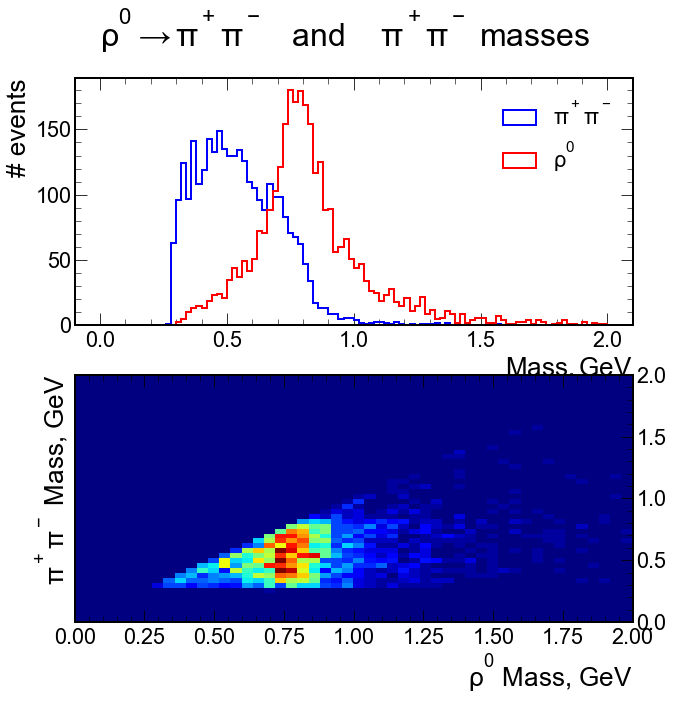

In [10]:
from modules.physics.analysis import pairs

# %matplotlib widget
#ShowMassComaprison(LiteHeavyRecoil, 'Lightest and Recoil Pairs')
LiteHeavyRecoil, LiteHeavyTotal = pairs.GetPairs(ft.GetTracksWithPtLt(ft.GetTracksWithNTPC(ft.four_tracks_zq,4)))

fig = pairs.ShowMassComaprison(LiteHeavyTotal, r'$\rho^0 \rightarrow \pi^+\pi^-$   and    $\pi^+\pi^-$ masses')
fig

As we can see above, for second case (all possible pairs) we've got stronger signal in comparison with light-recoil pair as it made in [STAR work](http://arxiv.org/abs/0912.0604v2). Let's build 2d distirbuition and marginals component separately:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


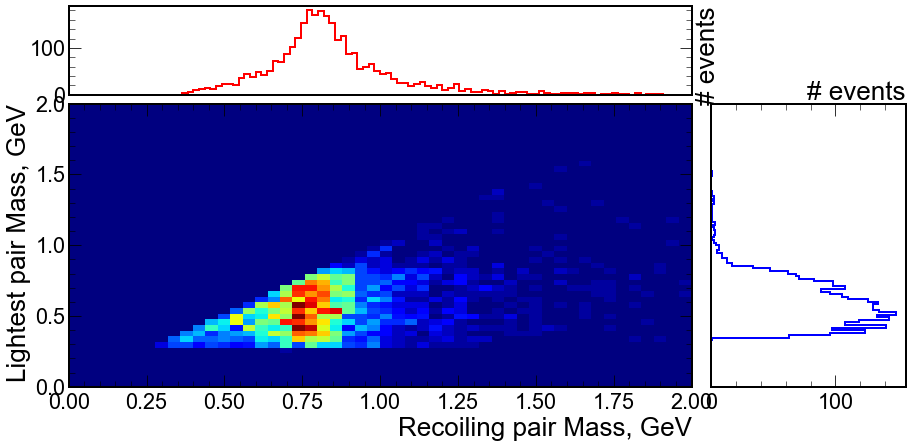

In [11]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

plt.style.use(hep.style.ROOT)

fig = plt.figure(figsize=(15, 7))

gs = GridSpec(4,4,wspace=0.1,hspace=0.1)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.hist2d(LiteHeavyTotal.Recoil, LiteHeavyTotal.Lite, bins=(50, 50), range=[(0, 2), (0, 2)], cmap=plt.cm.jet)
_ = ax_marg_y.hist(LiteHeavyTotal.Lite, bins=100, range=(0, 2), histtype='step', color='blue', linewidth=2, label='lite pair',orientation="horizontal")
_ = ax_marg_x.hist(LiteHeavyTotal.Recoil, bins=100, range=(0, 2), histtype='step', color='red', linewidth=2, label='rest pair')


ax_joint.set_ylabel('Lightest pair Mass, GeV')
ax_joint.set_xlabel('Recoiling pair Mass, GeV')

# ax_marg_y.set_xlabel('$Mass, GeV$')
ax_marg_y.set_xlabel('# events')
ax_marg_x.yaxis.set_label_position("right")
ax_marg_x.xaxis.set_ticks([])
ax_marg_x.xaxis.set_ticks_position('none')
ax_marg_y.yaxis.set_ticks_position('none')
ax_marg_y.yaxis.set_ticks([])

# ax_marg_x.set_xlabel('$Mass, GeV$')
ax_marg_x.set_ylabel('# events')
ax_marg_y.xaxis.set_label_position("top")
ax_marg_x
ax_joint.legend()
fig

## Cross section

Let's see to cross section of my events.

For this we should take luminosity of runs.

> Unfortunately file that I have to use for getting luminosity have a reference to special class AliTriggerInfo and moreover it packed into TObjArray, so I can't read it via uproot4. This is the reason why I used pure root again. [Here is the script](https://github.com/bdrum/cern-physics/blob/master/root-cpp/RhoPrime/macro/lumi.C) that I used.

Then let's see how much events do we have in each run.

$$L = \frac{1}{\sigma} \frac{\delta N}{\delta t}$$, this means that 

$$\sigma \approx \frac{N}{L}$$

Cross section of phenomena should be flat and independent from runs. 

Let's check it:

In [28]:
df_cs = GetCrossSection(ft.orig_events.RunNum, ft.GetTracksWithPtLt(ft.ft_zq_nTPC[0]))
df_cs['sigma'] = df_cs.nEvFT / (df_cs.Lumi * 1000)
df_cs.sigma.describe()


C:\Python38\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


count    119.000000
mean       5.611438
std        1.558305
min        1.621205
25%        4.630173
50%        5.584997
75%        6.479376
max       10.036004
Name: sigma, dtype: float64

In [29]:
import scipy.stats

fig = plt.figure(figsize=(25, 7))
# fig.suptitle("visible cross section")
ax = fig.add_subplot()
bins = list(df_cs.run)
cnts = list(df_cs.sigma)
errs = np.sqrt(df_cs.nEvFT)/(df_cs.Lumi * 1000)
x = np.arange(len(bins))
width = 0.15
ax.errorbar(x - width/2, cnts, yerr=errs, fmt='o', label=r'$\sigma \approx \frac{N_{(\pi^+\pi^-\pi^+\pi^-)_{ev}}}{L}$')
ax.set_xticks(x)
ax.set_xticklabels(bins, rotation=90, rotation_mode="anchor", ha="right", fontsize=12)
ax.set_ylabel(r'$\sigma$',fontsize=14)
ax.set_ylim(0,10)

chi2,p = scipy.stats.chisquare(cnts, np.tile(np.average(cnts),len(cnts)))
ax.text(108,8,r"$\frac{Chi^2}{NDf} = \frac{189.388}{118}$", size=20)
ax.text(108,7,r"$p0 = 4.4542 \pm 0.11613$", size=16)
ax.legend(prop={'size': 15})
ax.axhline(y=np.average(cnts), color='r', linestyle='-')
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Other decays

In PDG I've seen also other interesting modes for $\rho'$:

- 1. $\rho' \rightarrow \eta_0 \rho_0$ | ?
   - 1.1. $\rho_0 \rightarrow 4 \pi$ | $2*10^{-5}\%$
   - 1.2. $\rho_0 \rightarrow \pi^+ \pi^-$ | $10^{-2}\%$
   - 1.3. $\eta_0' \rightarrow  \pi^+ \pi^- \gamma$ | $4\%$
   - 1.4. $\eta_0' \rightarrow  \pi^+ \pi^- \pi^0$ | $23\%$
- 2. $\rho' \rightarrow 4 \pi$ | ?

What about $\rho' \rightarrow \rho_0 \rho_0$ is it possible?

## Decay angle for $\rho_0$

According to [65](https://arxiv.org/pdf/1903.00166.pdf) 

$$cos \theta = \frac{2E_{\pi}}{E_{\rho}-1} 1/ \sqrt{1 - 4\frac{m_{\pi}^2}{m_{\rho}^2}}$$

$$E_{\pi}=\sqrt{m_{\pi}^2+p_{\pi}^2}$$
$$E_{\rho}=\sqrt{m_{\rho}^2+p_{\rho}^2}$$

Very close result from [Landau T2 par.11 exc.2](file:///D:/GoogleDrive/Books/phys/%D0%9B%D0%B0%D0%BD%D0%B4%D0%B0%D1%83,%20%D0%9B%D0%B8%D1%84%D1%88%D0%B8%D1%86%20-%20%D0%A2%D0%B5%D0%BE%D1%80.%20%D1%84%D0%B8%D0%B7%D0%B8%D0%BA%D0%B0/%D0%9B%D0%B0%D0%BD%D0%B4%D0%B0%D1%83%20%D0%9B.%D0%94.,%20%D0%9B%D0%B8%D1%84%D1%88%D0%B8%D1%86%20%D0%95.%D0%9C.%20-%20%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F%20%D1%84%D0%B8%D0%B7%D0%B8%D0%BA%D0%B0.%20%D0%A2%D0%BE%D0%BC%2002%20%D0%B8%D0%B7%2010.%20%D0%A2%D0%B5%D0%BE%D1%80%D0%B8%D1%8F%20%D0%BF%D0%BE%D0%BB%D1%8F%20(2003.8.%D0%B8%D0%B7%D0%B4)(T).pdf)

$$\cos \theta = \frac{\sqrt{E^2-|P|E}-M_\rho/2}{\sqrt{M_\rho^2-4m_\pi^2}|P|/E}$$

In [27]:
LiteHeavyTotal.Recoil

entry
20        0.432236
42        0.630956
96        0.782677
198       1.014306
200       0.670207
            ...   
106367    1.163941
106383    1.260068
106461    0.911308
106497    0.889234
106687    0.899221
Name: Recoil, Length: 3008, dtype: float32

## $ \downarrow \downarrow \downarrow \downarrow$ DEBUG $ \downarrow \downarrow \downarrow \downarrow$


## $\uparrow$$\uparrow$$\uparrow$$\uparrow$ DEBUG $\uparrow$$\uparrow$$\uparrow$$\uparrow$
